# Huckleberry Labs Interview

Prompt:

```
1. Read the data

2. Prepare the data for modeling the value in the column named "real_or_fake?" (1 for real and 0 for fake)

3. Model the prediction of the column named "real_or_fake?"

4. Show how you have developed the method of scoring the models

5. The modeling with the best metric is far less important than the methodology used to perform steps 2-4
```

In [350]:
import string
import contractions
from spellchecker import SpellChecker
from wordcloud import STOPWORDS
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn import svm
from sklearn.linear_model import LogisticRegression


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spacy

import gensim
from gsdmm import MovieGroupProcess

pd.options.mode.chained_assignment = None 

In [2]:
sns.set_context("notebook")

In [360]:
np.random.seed(42)

In [62]:
nlp = spacy.load("en_core_web_lg")

## Load the data


In [4]:
df = pd.read_csv('presentation_data.csv')

In [5]:
df

,index_val,type_val,place,short_text,real_or_fake
0,1,NaN,NaN,Our Deeds are the Reason of this # earthquake...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask . Canada,1
2,5,NaN,NaN,All residents asked to ' shelter in place ' ...,1
3,6,NaN,NaN,"13,000 people receive # wildfires evacuation ...",1
4,7,NaN,NaN,Just got sent this photo from Ruby # Alaska a...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@ Aria Ahrary @ TheTawniest The out of contr...,1
7610,10871,NaN,NaN,M1 . 94 [ 01 : 04 UTC ] ? 5km S of Volcano H...,1
7611,10872,NaN,NaN,Police investigating after an e - bike collide...,1


<AxesSubplot:xlabel='real_or_fake', ylabel='count'>

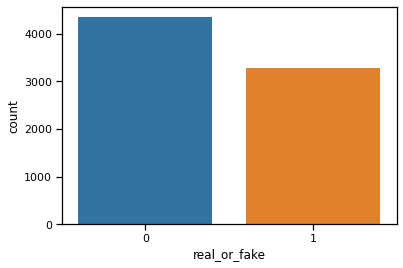

In [6]:
sns.countplot(x = 'real_or_fake', data=df) # not bad

## Impressions
- This text data seems to be Twitter data, which means that `place` will not be useful because this field is generated by the user and doesn't necessarily contain a real place
- Let's see if `type_val` contains any useful information

In [7]:
real_type_val = df.query("real_or_fake == 1")['type_val'].value_counts().reset_index().iloc[0:20]
fake_type_val = df.query("real_or_fake == 0")['type_val'].value_counts().reset_index().iloc[0:20]

<AxesSubplot:xlabel='type_val', ylabel='index'>

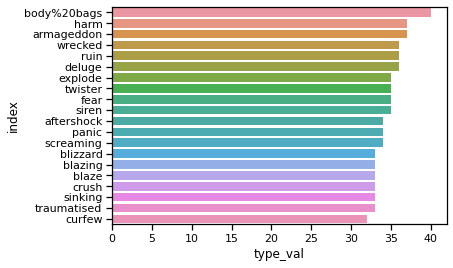

In [8]:
sns.barplot(y = 'index', x = 'type_val', data = fake_type_val)

- `type_val` may contain useful information since there is good separation between real and fake but it requires heavy cleaning
- for the model to be properly robust, especially for new data, we should use topic modeling to create our own `type_val`
- Use raw text data for topic modeling

## Pre-processing of Raw Text Data

In [9]:
len(df['index_val'].unique()) == len(df['index_val']) # check for duplicate indexes

True

In [10]:
# check for duplicates in `short_text`

df[df.duplicated(subset=['short_text'])]

# 632 duplicates is a lot. Let's check if the duplicates were consistently classified as real or fake 

,index_val,type_val,place,short_text,real_or_fake
48,68,ablaze,Live On Webcam,Check these out : # nsfw,0
106,156,aftershock,US,320 [ IR ] ICEMOON [ AFTERSHOCK ] | | ...,0
114,164,aftershock,Switzerland,320 [ IR ] ICEMOON [ AFTERSHOCK ] | | ...,0
115,165,aftershock,US,320 [ IR ] ICEMOON [ AFTERSHOCK ] | | ...,0
116,168,aftershock,NaN,320 [ IR ] ICEMOON [ AFTERSHOCK ] | | ...,0
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@ Aria Ahrary @ TheTawniest The out of contr...,1
7610,10871,NaN,NaN,M1 . 94 [ 01 : 04 UTC ] ? 5km S of Volcano H...,1
7611,10872,NaN,NaN,Police investigating after an e - bike collide...,1


In [11]:
dupes_mean = df.groupby('short_text').mean()
dupes_mean
# if the mean is not 0 or 1, then that means that `real_or_fake` was inconsistent between duplicates
# let's drop the inconsistencies for now. 
# but in reality we would be double checking 1) why duplicates occurred (scraping or API issue?) and 2) why were they categorized differently?

,index_val,real_or_fake
short_text,,
\nANOTHER DISASTER WAITING TO HAPPEN AND YOUR ALLOWING IT ?,7255.0,1.0
\nCROYDON RIOTS - The Next Day : Burning Buildings in High Street & crowds at Reeves Corner\nCroydonization\nAugust 2011,1770.0,1.0
\nSON OF SAVIOR LAVA VIDEO,6724.0,0.0
\nSeems they declared war against government .,6455.0,1.0
# ArtisteOfTheWeekFact say # Conversations by # coast2coastdjs agree @ Crystal_Blaz ' s # Jiwonle is a # HipHop # ClubBanger,978.0,0.0
...,...,...
you wrecked my whole world,10811.0,0.0
~ More wicked weather rolls through Calgary and surrounding areas,5847.0,1.0
~Still echoes of their screams~,8560.0,0.0


In [12]:
remove_text = dupes_mean.query("real_or_fake != 1 & real_or_fake != 0").reset_index()['short_text'].to_list()

In [13]:
len(remove_text)
# 66 lines of text need to be removed due to inconsistent classification

66

In [14]:
df.query('short_text not in @remove_text', inplace=True)
df

# Shouldn't necessarily remove duplicates because retweets contain information too

,index_val,type_val,place,short_text,real_or_fake
0,1,NaN,NaN,Our Deeds are the Reason of this # earthquake...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask . Canada,1
2,5,NaN,NaN,All residents asked to ' shelter in place ' ...,1
3,6,NaN,NaN,"13,000 people receive # wildfires evacuation ...",1
4,7,NaN,NaN,Just got sent this photo from Ruby # Alaska a...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@ Aria Ahrary @ TheTawniest The out of contr...,1
7610,10871,NaN,NaN,M1 . 94 [ 01 : 04 UTC ] ? 5km S of Volcano H...,1
7611,10872,NaN,NaN,Police investigating after an e - bike collide...,1


In [15]:
# we need to be able to grab contractions and expand them
# the raw data has a space to separate the word "can't" => "can ' t"
df['short_text'] = df['short_text'].str.replace(" ' ", "'") # make the contractions again
df['short_text'] = df['short_text'].apply(lambda x: contractions.fix(x)) # expand contractions

In [16]:
# now we removed input with inconsistent real_or_fake
# lets keep cleaning

df['clean_text'] = df['short_text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df['clean_text'] = df['clean_text'].str.replace('\s+', ' ', regex=True) # remove multiple spaces

In [17]:
df['lower_clean_text'] = df['clean_text'].str.lower()
df['spell_checked_text'] = df['lower_clean_text'] 

In [18]:
spell = SpellChecker()

df['spell_checked_text'].apply(lambda x: spell.correction(x))

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609     aria ahrary thetawniest the out of control wi...
7610             m1 94 01 04 utc 5km s of volcano hawaii 
7611    police investigating after an e bike collided ...
7612    the latest more homes razed by northern califo...
Name: spell_checked_text, Length: 7382, dtype: object

In [19]:
# let's remove some stopwards

df['super_clean_text'] = df['spell_checked_text'].apply(lambda x: [item for item in x.split(' ') if item not in STOPWORDS])
df['super_clean_text'] = df['super_clean_text'].apply(lambda strings: [x for x in strings if x]) # remove empty strings


In [20]:
df['temp_docs'] = df['super_clean_text'].str.join(' ').apply(lambda x: nlp(x))
df['lemmatized_text'] = df['temp_docs'].apply(lambda x: " ".join([token.lemma_ for token in x]))

In [21]:
df['lemmatized_text'] = df['lemmatized_text'].apply(lambda s: ''.join([i for i in s if not i.isdigit()])) # remove numbers
df['lemmatized_text'] = df['lemmatized_text'].str.split(' ') 

In [22]:
df['lemmatized_text'] = df['lemmatized_text'].apply(lambda s: ' '.join([i for i in s if len(s) > 1])) # remove strings that are 0 or 1 again

In [23]:
df['lemmatized_text'] = df['lemmatized_text'].str.replace('\s+', ' ', regex=True) # remove multiple spaces

## EDA Generation

In [24]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

# Unigrams
real_unigrams = defaultdict(int)
fake_unigrams = defaultdict(int)

real_bigrams = defaultdict(int)
fake_bigrams = defaultdict(int)

real_trigrams = defaultdict(int)
fake_trigrams = defaultdict(int)

for text in df.query("real_or_fake == 1")['spell_checked_text']:
    for word in generate_ngrams(text, n_gram=1):
        real_unigrams[word] += 1
    for word in generate_ngrams(text, n_gram=2):
        real_bigrams[word] += 1
    for word in generate_ngrams(text, n_gram=3):
        real_trigrams[word] += 1
        
for text in df.query("real_or_fake == 0")['spell_checked_text']:
    for word in generate_ngrams(text, n_gram=1):
        fake_unigrams[word] += 1
    for word in generate_ngrams(text, n_gram=2):
        fake_bigrams[word] += 1
    for word in generate_ngrams(text, n_gram=3):
        fake_trigrams[word] += 1

def create_df_from_sorted_dct(dct): 
    df = pd.DataFrame(sorted(dct.items(), key=lambda x: x[1])[::-1])
    df.columns = ['ngram', 'frequency']
    df = df.iloc[:20] # just take the top 20 words
    return df

In [25]:
df_real_uni = create_df_from_sorted_dct(real_unigrams)
df_fake_uni = create_df_from_sorted_dct(fake_unigrams)

df_real_bi = create_df_from_sorted_dct(real_bigrams)
df_fake_bi = create_df_from_sorted_dct(fake_bigrams)

df_real_tri = create_df_from_sorted_dct(real_trigrams)
df_fake_tri = create_df_from_sorted_dct(fake_trigrams)

<AxesSubplot:xlabel='frequency', ylabel='ngram'>

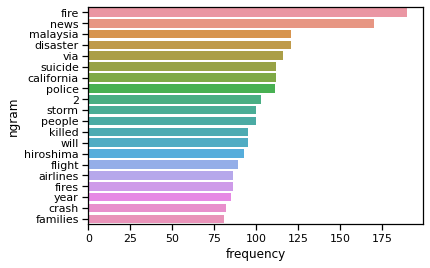

In [26]:
# Real Unigram
sns.barplot(y = 'ngram', x = 'frequency', data = df_real_uni)

<AxesSubplot:xlabel='frequency', ylabel='ngram'>

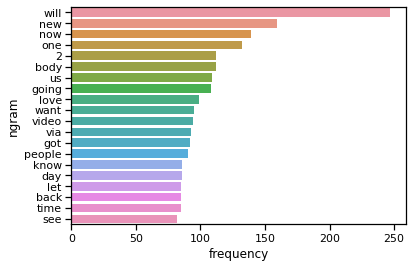

In [27]:
# Fake Unigram
sns.barplot(y = 'ngram', x = 'frequency', data = df_fake_uni)

In [28]:
df['lemmatized_text'].apply(lambda x: x.split(' '))

0       [deed, reason, earthquake, may, allah, forgive...
1           [forest, fire, near, la, ronge, sask, canada]
2       [resident, ask, shelter, place, notify, office...
3       [, people, receive, wildfire, evacuation, orde...
4       [got, send, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, crane, hold, bridge, collapse, ne...
7609    [aria, ahrary, thetawni, control, wild, fire, ...
7610                     [m, utc, km, s, volcano, hawaii]
7611    [police, investigate, e, bike, collide, car, l...
7612    [late, home, raze, northern, california, wildf...
Name: lemmatized_text, Length: 7382, dtype: object

#### Individual Topic Modeling from using GSDMM
-  Gibbs sampling algorithm for a Dirichlet Mixture Model is more appropriate for short text and matches our assumption that there should only be one topic per row

In [29]:
# input needs to be a list of lists of string
lst_strings = df['lemmatized_text'].apply(lambda x: x.split(' '))
gsdmm_docs = [list(filter(None, lst)) for lst in lst_strings] # remove blank strings
gsdmm_docs = [x for x in gsdmm_docs if len(x) > 2]

# create dictionary of all words in all documents
gsdmm_dct = gensim.corpora.Dictionary(gsdmm_docs)

# filter extreme cases out of dictionary
gsdmm_dct.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# create variable containing length of dictionary/vocab
vocab_length = len(gsdmm_dct)

# create bag of words dictionary
bow_corpus = [gsdmm_dct.doc2bow(doc) for doc in gsdmm_docs]

# initialize GSDMM
# arbitrary hyperparameters here, assume 15 clusters
gsdmm = MovieGroupProcess(K=15, alpha=0.5, beta=0.1, n_iters=15)
# Alpha controls the probability that a student will join a table that is currently empty
# beta: Beta controls the student's affinity for other students with similar interests. Low means higher affinity and less on popularity

# fit GSDMM model
gsdmm_out = gsdmm.fit(gsdmm_docs, vocab_length)

In stage 0: transferred 5867 clusters with 15 clusters populated
In stage 1: transferred 2975 clusters with 15 clusters populated
In stage 2: transferred 2131 clusters with 15 clusters populated
In stage 3: transferred 1802 clusters with 15 clusters populated
In stage 4: transferred 1644 clusters with 15 clusters populated
In stage 5: transferred 1582 clusters with 15 clusters populated
In stage 6: transferred 1381 clusters with 15 clusters populated
In stage 7: transferred 1311 clusters with 15 clusters populated
In stage 8: transferred 1248 clusters with 15 clusters populated
In stage 9: transferred 1247 clusters with 15 clusters populated
In stage 10: transferred 1235 clusters with 15 clusters populated
In stage 11: transferred 1254 clusters with 15 clusters populated
In stage 12: transferred 1217 clusters with 15 clusters populated
In stage 13: transferred 1155 clusters with 15 clusters populated
In stage 14: transferred 1123 clusters with 15 clusters populated


In [30]:
# print number of documents per topic
doc_count = np.array(gsdmm.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)

# define function to get top words per topic
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))

# get top words in topic
top_words(gsdmm.cluster_word_distribution, top_index, 20)

Number of documents per topic : [ 453  385  421 1118  391  336  443  412  637  429  404  381  522  465
  380]
Most important clusters (by number of docs inside): [ 3  8 12 13  0  6  9  2  7 10  4  1 11 14  5]

Cluster 3 : [('go', 133), ('will', 84), ('one', 75), ('see', 69), ('get', 57), ('body', 57), ('want', 56), ('day', 53), ('make', 53), ('come', 53), ('let', 48), ('know', 47), ('we', 44), ('think', 44), ('now', 44), ('look', 44), ('say', 43), ('love', 43), ('time', 43), ('back', 42)]

Cluster 8 : [('fire', 42), ('will', 39), ('first', 35), ('get', 33), ('new', 33), ('go', 30), ('god', 28), ('now', 27), ('video', 27), ('man', 26), ('burn', 26), ('love', 26), ('good', 26), ('help', 25), ('know', 25), ('day', 25), ('one', 24), ('back', 22), ('injury', 22), ('take', 22)]

Cluster 12 : [('will', 44), ('go', 39), ('mudslide', 34), ('fire', 32), ('people', 30), ('see', 29), ('want', 29), ('building', 26), ('burn', 26), ('love', 26), ('one', 25), ('feel', 24), ('thing', 24), ('look', 23),

In [48]:
# finally, lets get the cluster information for each text
df['cluster'] = df['lemmatized_text'].str.split(' ').apply(lambda x: gsdmm.choose_best_label(x)[0])

<AxesSubplot:xlabel='cluster', ylabel='count'>

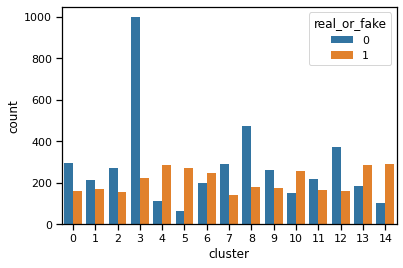

In [50]:
sns.countplot(x = 'cluster', hue='real_or_fake', data=df)
# some clusters perform better than others. clustering needs some optimization

##### Cluster 3 information:

```
Cluster 3 : [('go', 133), ('will', 84), ('one', 75), ('see', 69), ('get', 57), ('body', 57), ('want', 56), ('day', 53), ('make', 53), ('come', 53), ('let', 48), ('know', 47), ('we', 44), ('think', 44), ('now', 44), ('look', 44), ('say', 43), ('love', 43), ('time', 43), ('back', 42)]
```

- No event specific words, so it makes sense that it has a high number of 0 for `real_or_fake`

##### Cluster 4 and 5 information:

- In contrast, let's check Clusters 4 and 5, which have a relatively low number of "fake":

```
Cluster 4 : [('kill', 72), ('suicide', 71), ('hiroshima', 61), ('bombing', 57), ('bomb', 46), ('saudi', 38), ('crash', 37), ('mosque', 35), ('atomic', 33), ('bomber', 32), ('attack', 31), ('earthquake', 27), ('s', 25), ('sinkhole', 25), ('japan', 24), ('utc', 23), ('km', 23), ('time', 22), ('th', 22), ('year', 21)]

Cluster 5 : [('malaysia', 120), ('flight', 89), ('airlines', 75), ('police', 56), ('attack', 46), ('confirm', 45), ('crash', 42), ('debris', 40), ('wreckage', 38), ('investigator', 37), ('spill', 33), ('family', 33), ('oil', 33), ('reunion', 31), ('suspect', 31), ('officer', 30), ('find', 28), ('via', 28), ('news', 28), ('pm', 28)]
```

We can see that it makes sense for these clusters have good separation between real and fake. These clusters could use some optimization, however.



In [202]:
vocab = set()
for s in df['temp_docs']:
    vocab.update(set(s))

In [203]:
vectors = []
for token in list(vocab):
    vectors.append(token.vector)

In [252]:
vect = TfidfVectorizer()
tfidf_matrix = vect.fit_transform(df['lemmatized_text'])
results_df = pd.DataFrame(tfidf_matrix.toarray(), columns = vect.get_feature_names_out())
results_df

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aaceorg,aal,aan,aannnnd,aar,...,zourryart,zrnf,zss,zumiez,zurich,zxathetis,zzzz,ââ,ìñ,ìü
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [283]:
cluster_array = pd.get_dummies(data = df['cluster'], columns=['cluster'])

In [286]:
X_cluster = cluster_array.to_numpy()

In [287]:
X_tfidf = tfidf_matrix.toarray()

In [307]:
X = np.concatenate((X_cluster, X_tfidf), axis=1)

In [328]:
y = df['real_or_fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['cluster'], shuffle=True)

In [330]:
# Initialize SVM classifier
svm_clf = svm.SVC(kernel='linear')
svm_clf = svm_clf.fit(X_train, y_train)

In [331]:
svm_y_pred = svm_clf.predict(X_test)

/Users/johntan/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


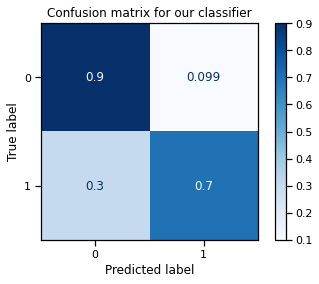

In [335]:
matrix = plot_confusion_matrix(svm_clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

In [348]:
def metrics_fx(y_true, y_pred):
    
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    auc = metrics.roc_auc_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    
    return pd.DataFrame([accuracy, precision, recall, auc, f1], index = ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1'])

In [349]:
metrics_fx(y_test, svm_y_pred)

,0
Accuracy,0.815166
Precision,0.838772
Recall,0.698083
AUC,0.799688
F1,0.761988


## Cross-Validation


In [362]:
cv = RepeatedKFold(n_splits=10, n_repeats=3)

In [363]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

scores = cross_val_score(svm_clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))